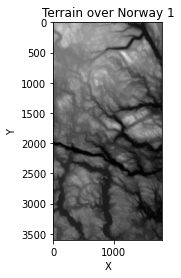

In [1]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
# Load the terrain
terrain = imread('data/SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')plt.show()


In [2]:
def create_X(x, y, n):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X[:, 1:]

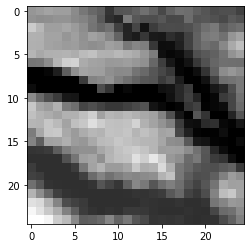

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

z = terrain[2000:2500:20, 500:1000:20]
z -= np.min(z)
z = z / np.max(z)

plt.imshow(z, cmap='gray')

x = np.linspace(0, 1, np.shape(z)[0])
y = np.linspace(0, 1, np.shape(z)[1])
x, y = np.meshgrid(x,y)

# __OLS__

In [4]:
from sklearn.linear_model import LinearRegression

RANDOM_STATE = 410
max_degree = 16
degrees = np.arange(1, max_degree)

ols_train_MSE = np.zeros(max_degree - 1)
ols_test_MSE = np.zeros(max_degree - 1)
ols_r2 = np.zeros(max_degree - 1)
ols_cv_score = np.zeros(max_degree - 1)

for i in tqdm(degrees):
    X = create_X(x, y, i)

    X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

    model = make_pipeline(StandardScaler(), LinearRegression())
    model.fit(X_train, z_train)
    z_tilde = model.predict(X_train)
    z_pred = model.predict(X_test)

    ols_train_MSE[i - 1] = mean_squared_error(z_train, z_tilde)
    ols_test_MSE[i - 1] = mean_squared_error(z_test, z_pred)
    ols_r2[i - 1] = r2_score(z_test, z_pred)

100%|██████████| 15/15 [00:00<00:00, 17.34it/s]


In [5]:
for i in tqdm(degrees):
    X = create_X(x, y, i)
    model = make_pipeline(StandardScaler(), LinearRegression())
    ols_cv_score[i - 1] = -np.mean(cross_val_score(model, X, z.reshape(-1, 1), scoring='neg_mean_squared_error', cv=KFold(10, shuffle=True)))

100%|██████████| 15/15 [00:02<00:00,  6.39it/s]


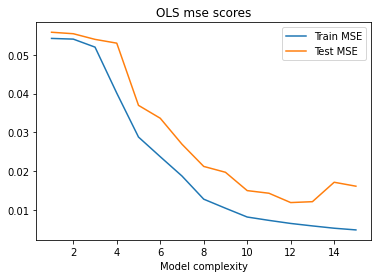

In [6]:
fig, ax = plt.subplots()
ax.plot(degrees, ols_train_MSE, label='Train MSE')
ax.plot(degrees, ols_test_MSE, label='Test MSE')
ax.legend()
ax.set_title('OLS mse scores')
ax.set_xlabel('Model complexity')
plt.show()

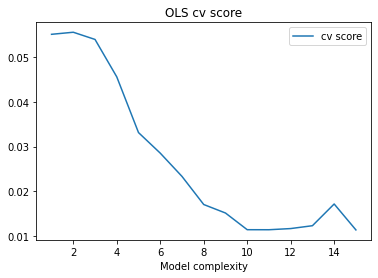

In [7]:
fig, ax = plt.subplots()
ax.plot(degrees, ols_cv_score, label='cv score')
ax.legend()
ax.set_title('OLS cv score')
ax.set_xlabel('Model complexity')
plt.show()

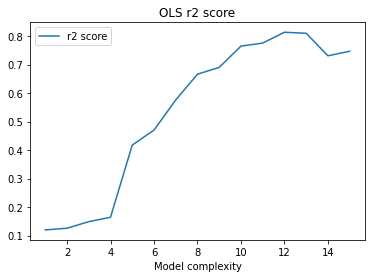

In [8]:
fig, ax = plt.subplots()
ax.plot(degrees, ols_r2, label='r2 score')
ax.legend()
ax.set_title('OLS r2 score')
ax.set_xlabel('Model complexity')
plt.show()

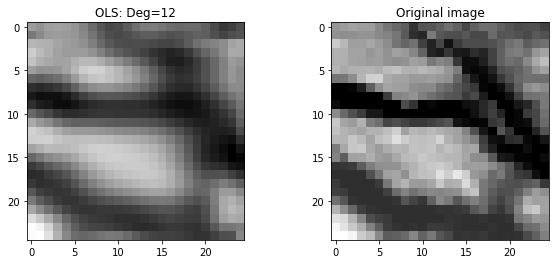

In [9]:
X = create_X(x, y, 12)

X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(X_train, z_train)
z_pred = model.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(model.predict(X).reshape(z.shape), cmap='gray')
ax1.set_title('OLS: Deg=12')
ax2.imshow(z, cmap='gray')
ax2.set_title('Original image')
fig.set_figwidth(10)

# __Ridge__

In [10]:
from sklearn.linear_model import Ridge

num_lambdas = 20
degree = 19

lambdas = np.logspace(-6, 6, num_lambdas)

ridge_train_MSE = np.zeros(num_lambdas)
ridge_test_MSE = np.zeros(num_lambdas)
ridge_r2 = np.zeros(num_lambdas)
ridge_cv_score = np.zeros(num_lambdas)

itr = 0
for lmb in tqdm(lambdas):
    X = create_X(x, y, degree)

    X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

    model = make_pipeline(StandardScaler(), Ridge(lmb, fit_intercept=True))
    model.fit(X_train, z_train)
    z_tilde = model.predict(X_train)
    z_pred = model.predict(X_test)

    ridge_train_MSE[itr] = mean_squared_error(z_train, z_tilde)
    ridge_test_MSE[itr] = mean_squared_error(z_test, z_pred)
    ridge_r2[itr] = r2_score(z_test, z_pred)
    itr += 1

100%|██████████| 20/20 [00:01<00:00, 12.68it/s]


In [11]:
cv_score_itr = 0
for lmb in tqdm(lambdas):
    X = create_X(x, y, degree)
    model = make_pipeline(StandardScaler(), Ridge(lmb, fit_intercept=True))
    ridge_cv_score[cv_score_itr] = -np.mean(cross_val_score(model, X, z.reshape(-1, 1), scoring='neg_mean_squared_error', cv=KFold(10, shuffle=True)))
    cv_score_itr += 1

100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


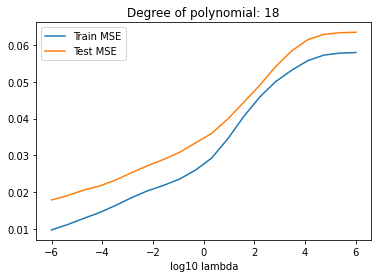

In [12]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), ridge_train_MSE, label='Train MSE')
ax.plot(np.log10(lambdas), ridge_test_MSE, label='Test MSE')
ax.legend()
ax.set_title('Degree of polynomial: {}'.format(degree - 1))
ax.set_xlabel('log10 lambda')
plt.show()

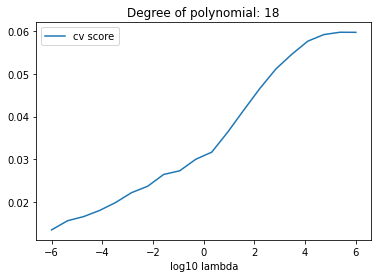

In [13]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), ridge_cv_score, label='cv score')
ax.legend()
ax.set_title('Degree of polynomial: {}'.format(degree - 1))
ax.set_xlabel('log10 lambda')
plt.show()

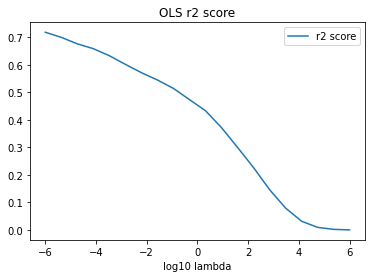

In [14]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), ridge_r2, label='r2 score')
ax.legend()
ax.set_title('OLS r2 score')
ax.set_xlabel('log10 lambda')
plt.show()

Below we perform a gridsearch to find the optimal polynomial degree and lambda value

In [15]:
max_degree = 20
degrees = np.arange(1, max_degree)

ridge_r2_grid = np.zeros((max_degree - 1, num_lambdas))

for deg in degrees:
    lmb_itr = 0
    for lmb in tqdm(lambdas):
        X = create_X(x, y, deg)

        X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

        model = make_pipeline(StandardScaler(), Ridge(lmb, fit_intercept=True))
        model.fit(X_train, z_train)
        z_pred = model.predict(X_test)

        ridge_r2_grid[deg - 1, lmb_itr] = r2_score(z_test, z_pred)
        lmb_itr += 1

100%|██████████| 20/20 [00:01<00:00, 17.21it/s]


(array([18]), array([0]))


([<matplotlib.axis.XTick at 0x7f3a56f0bb38>,
 [Text(0, 0, '-6'), Text(5, 0, '-3'), Text(10, 0, '0'), Text(15, 0, '3')])

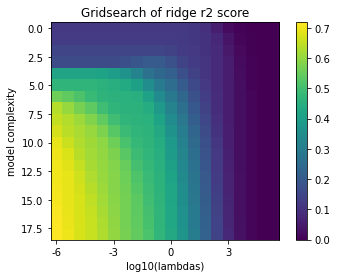

In [16]:
idx = np.where(ridge_r2_grid == np.amax(ridge_r2_grid))
print(idx)

fig, ax = plt.subplots()
cb = ax.imshow(ridge_r2_grid)
ax.set_xlabel('log10(lambdas)')
ax.set_ylabel('model complexity')
ax.set_title('Gridsearch of ridge r2 score')
plt.colorbar(cb)
plt.xticks(range(0, num_lambdas, 5), range(-6, 6, 3))

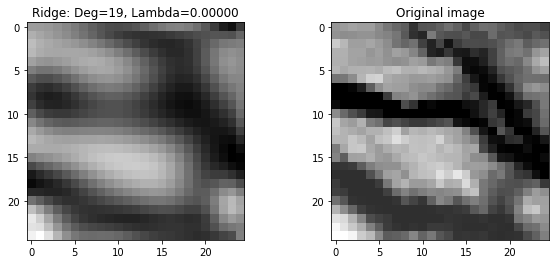

In [17]:
from sklearn.linear_model import Ridge
X = create_X(x, y, idx[0][0])

X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

model = make_pipeline(StandardScaler(), Ridge(lambdas[idx[1]], fit_intercept=True))
model.fit(X_train, z_train)
z_pred = model.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(model.predict(X).reshape(z.shape), cmap='gray')
ax1.set_title('Ridge: Deg={}, Lambda={:.5f}'.format(degrees[idx[0][0]], lambdas[idx[1][0]]))
ax2.imshow(z, cmap='gray')
ax2.set_title('Original image')
fig.set_figwidth(10)

# Lasso

In [18]:
from sklearn.linear_model import Lasso

num_lambdas = 20
degree = 13

lambdas = np.logspace(-6, 6, num_lambdas)

train_MSE = np.zeros(num_lambdas)
test_MSE = np.zeros(num_lambdas)
cv_score = np.zeros(num_lambdas)

mse_itr = 0
for lmb in tqdm(lambdas):
    X = create_X(x, y, degree)

    X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

    model = make_pipeline(StandardScaler(), Lasso(lmb, fit_intercept=True))
    model.fit(X_train, z_train)
    z_tilde = model.predict(X_train)
    z_pred = model.predict(X_test)

    train_MSE[mse_itr] = mean_squared_error(z_tilde, z_train)
    test_MSE[mse_itr] = mean_squared_error(z_pred, z_test)
    mse_itr += 1

  0%|          | 0/20 [00:00<?, ?it/s]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.851751150836732, tolerance: 0.002535132729780124
  positive)
/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.7224369898058445, tolerance: 0.002535132729780124
  positive)
 10%|█         | 2/20 [00:00<00:02,  8.25it/s]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.169293008534446, tolerance: 0.002535132729780124
  positive)
 15%|█▌        | 3/20 [00:00<00:02,  7.57it/s]/home/hakon/.local/lib/python3.6/site-packages/skl

In [19]:
cv_score_itr = 0
for lmb in tqdm(lambdas):
    X = create_X(x, y, degree)
    model = make_pipeline(StandardScaler(), Lasso(lmb, fit_intercept=True))
    cv_score[cv_score_itr] = -np.mean(cross_val_score(model, X, z.reshape(-1, 1), scoring='neg_mean_squared_error', cv=KFold(10, shuffle=True)))
    cv_score_itr += 1

  0%|          | 0/20 [00:00<?, ?it/s]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.85900348932199, tolerance: 0.003322174304705971
  positive)
/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.8822238987931925, tolerance: 0.0032966200171050107
  positive)
/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.035010101201989, tolerance: 0.00333058242065393
  positive)
/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge.

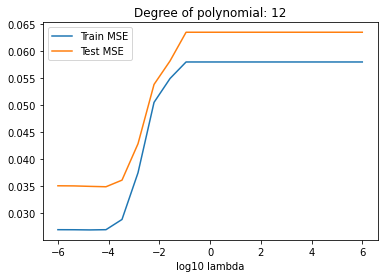

In [20]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), train_MSE, label='Train MSE')
ax.plot(np.log10(lambdas), test_MSE, label='Test MSE')
ax.legend()
ax.set_title('Degree of polynomial: {}'.format(degree - 1))
ax.set_xlabel('log10 lambda')
plt.show()

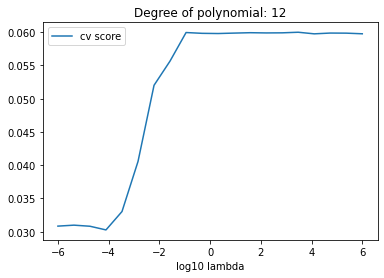

In [21]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), cv_score, label='cv score')
ax.legend()
ax.set_title('Degree of polynomial: {}'.format(degree - 1))
ax.set_xlabel('log10 lambda')
plt.show()

In [22]:
from sklearn.linear_model import Lasso

max_degree = 20
degrees = np.arange(1, max_degree)

lambdas = np.logspace(-6, 6, num_lambdas)

lasso_r2_grid = np.zeros((max_degree - 1, num_lambdas))

for deg in degrees:
    lmb_itr = 0
    for lmb in tqdm(lambdas):
        X = create_X(x, y, deg)

        X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

        model = make_pipeline(StandardScaler(), Lasso(lmb, fit_intercept=True))
        model.fit(X_train, z_train)
        z_pred = model.predict(X_test)

        lasso_r2_grid[deg - 1, lmb_itr] = r2_score(z_test, z_pred)
        lmb_itr += 1

61857995132, tolerance: 0.002535132729780124
  positive)
  0%|          | 0/20 [00:00<?, ?it/s]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.075953865115763, tolerance: 0.002535132729780124
  positive)
/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.996140149369805, tolerance: 0.002535132729780124
  positive)
 10%|█         | 2/20 [00:00<00:01, 14.39it/s]/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.658278433388055, tolerance: 0.002535132729780124
  positive)
/home/hakon/.local/lib/python3.6/site-pa

([<matplotlib.axis.XTick at 0x7f3a542472b0>,
 [Text(0, 0, '-6'), Text(5, 0, '-3'), Text(10, 0, '0'), Text(15, 0, '3')])

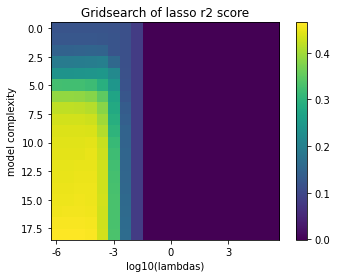

In [23]:
idx = np.where(lasso_r2_grid == np.amax(lasso_r2_grid))

fig, ax = plt.subplots()
cb = ax.imshow(lasso_r2_grid)
ax.set_xlabel('log10(lambdas)')
ax.set_ylabel('model complexity')
ax.set_title('Gridsearch of lasso r2 score')
plt.colorbar(cb)
plt.xticks(range(0, num_lambdas, 5), range(-6, 6, 3))

/home/hakon/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.255403485520313, tolerance: 0.002535132729780124
  positive)


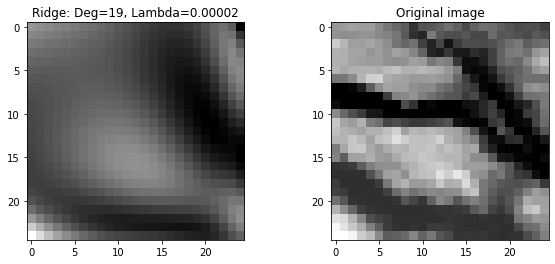

In [24]:
X = create_X(x, y, idx[0][0])

X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

model = make_pipeline(StandardScaler(), Lasso(lambdas[idx[1]], fit_intercept=True))
model.fit(X_train, z_train)
z_pred = model.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(model.predict(X).reshape(z.shape), cmap='gray')
ax1.set_title('Ridge: Deg={}, Lambda={:.5f}'.format(degrees[idx[0][0]], lambdas[idx[1][0]]))
ax2.imshow(z, cmap='gray')
ax2.set_title('Original image')
fig.set_figwidth(10)